In [1]:
import re, os, sys
import numpy as np
import pandas as pd
import datetime
from bs4 import BeautifulSoup
import time
import urllib.request
import matplotlib.pyplot as plt
import sklearn

path_parsed_result='./static/csv/stock_list/pd_sum.pickle'
pd_sum=pd.read_pickle(path_parsed_result)
pd_sum=pd_sum.loc[pd_sum.value!='-']
pd_sum=pd_sum.rename(columns={'exchange_ticker': 'ticker'})


In [2]:

pd_temp=pd_sum.groupby('item_id').size()

merge_cols=['ticker', 'time']
pd_data=pd_sum[merge_cols].drop_duplicates()
pd_data=pd_data.merge(pd_sum[['ticker', 'template']].drop_duplicates(), left_on='ticker', right_on='ticker', how='inner')

item_id_list=list(pd_sum.item_id.unique())
for item_id in item_id_list:
    pd_sum_item=pd_sum.loc[pd_sum.item_id==item_id][merge_cols+['value']].rename(columns={'value': item_id}).drop_duplicates()
    pd_sum_item[item_id]=pd_sum_item[item_id].astype(str)
    pd_sum_item=pd_sum_item.loc[~pd_sum_item[item_id].str.upper().str.contains('NA')]
    pd_sum_item[item_id]=pd_sum_item[item_id].astype(np.float)
    pd_sum_item=pd_sum_item.groupby(merge_cols)[item_id].mean().reset_index()
    pd_data=pd_data.merge(pd_sum_item, left_on=merge_cols, right_on=merge_cols, how='outer')

pd_data_ori=pd_data.copy()

In [3]:
pd_data=pd_data_ori.copy()
pd_data['time']=pd.to_datetime(pd_data['time'])
pd_data['Accumulated Depreciation']=pd_data['Accumulated Depreciation'].abs()
merge_cols=['ticker', 'time', 'template']
pd_merge_cols=pd_data[merge_cols]

value_keys=[i for i in pd_data.keys() if not(i in merge_cols)]
share_keys=['Share Price', 'Diluted EPS']
cap_keys=[i for i in value_keys if not(i in share_keys)]

key_norm='Market Capitalization'
pd_data_abs=pd_data.copy()
pd_data_abs[cap_keys]=pd_data[cap_keys].abs()
pd_ticker_mean=pd_data_abs.groupby('ticker')[cap_keys].mean().reset_index()
pd_ticker_mean=pd_merge_cols.merge(pd_ticker_mean, left_on='ticker', right_on='ticker', how='inner')


# Normalization: use each stock's own absolute-time-mean-marketcap value as normalizer (company size normalize)
# Then normalize by the column std 
for key in cap_keys:
    pd_data[key]=pd_data[key]/pd_ticker_mean[key_norm]
    pd_data[key]=pd_data[key]/pd_data[key].std()/3
    
    
n_threshold=4
pd_data_n=pd_data.groupby('ticker').size()
pd_data_n=pd_data_n.loc[pd_data_n>=n_threshold]
ticker_list=pd_data_n.reset_index()['ticker']
pd_data=pd_data.loc[pd_data.ticker.isin(ticker_list)]
len(pd_data)

pd_data=pd_data.sort_values(by=['ticker', 'time'])

pd_data_nan=pd_data.copy()

In [4]:
if 1==0:
    pd_data_impute.isna().sum()
    pd_temp=pd_data_impute.isna()
    pd_temp[['ticker', 'time', 'template']]=pd_data_impute[['ticker', 'time', 'template']]
    pd_temp1=pd_temp.groupby(['ticker', 'template']).sum()
    pd_temp1['ratio']=pd_temp.groupby(['ticker', 'template']).sum().sum(axis=1)/pd_temp.groupby(['ticker']).size()
    pd_temp1=pd_temp1.reset_index()
    pd_temp1=pd_temp1.loc[pd_temp1.template=='Standard']
    pd_temp1.sort_values(by='ratio', ascending=False).head(15)
    #pd_temp1.loc[pd_temp1.ticker.str.contains('XCE')].T

In [20]:
def get_score(x, y):
    #if x.shape
    x, y=np.asarray(x), np.asarray(y)
    if len(x.shape)==1:
        x=x.reshape(len(x),1)
    if len(y.shape)>1:
        y=y.reshape(len(y))
    
    model_lin=sklearn.linear_model.LinearRegression()
    model_lin.fit(x,y)
    return model_lin.score(x, y)

def impute_session(method_impute, impute_key_list, pd_data_nan, sep_keys=['eqp_chamber'], MP_id=1, MP_queue=''):

    ###################################################################################################
    ### interation initialization
    
    pd_eqp_chamber=pd_data_nan[sep_keys].drop_duplicates()
    
    pd_output_entry_list=[]
    try:
        a=time_start
    except:
        time_start=time.time()
    
    for i in range(len(pd_eqp_chamber)):
        pd_eqp_chamber_entry=pd_eqp_chamber.iloc[[i]][sep_keys]
        pd_output_entry=pd_data_nan.merge(pd_eqp_chamber_entry, left_on=sep_keys, right_on=sep_keys, how='inner').copy()
        pd_output_entry=pd_output_entry.set_index(np.arange(len(pd_output_entry)))
        n_pd_output_entry=len(pd_output_entry)
        
        
        if method_impute in ['Nearest', 'ARIMA', 'Random']:
            j=-1
            for key in impute_key_list:
                j+=1
                if method_impute=='Nearest':
                    if np.isnan(pd_output_entry[key].iloc[0]):
                        try:
                            first_value=pd_output_entry.loc[~pd_output_entry[key].isna()][key].iloc[0]
                            pd_output_entry.loc[0,key]=first_value
                        except:
                            a=1

                    if np.isnan(pd_output_entry[key].iloc[-1]):
                        try:
                            last_value=pd_output_entry.loc[~pd_output_entry[key].isna()][key].iloc[-1]
                            pd_output_entry.loc[n_pd_output_entry-1,key]=last_value
                        except:
                            a=1
                    pd_output_entry[key]=pd_output_entry[key].interpolate(method='nearest', limit_direction='forward')

                elif method_impute=='Random':
                    unique_value_list=np.asarray(pd_output_entry[key].dropna().unique())
                    n_na=len(pd_output_entry.loc[pd_output_entry[key].isna()])
                    random_pick_ind=np.random.randint(len(unique_value_list), size=(n_na,))
                    pd_output_entry.loc[pd_output_entry[key].isna(), key]=unique_value_list[random_pick_ind]

                elif method_impute=='ARIMA':
                    if np.isnan(pd_output_entry[key].iloc[0]):
                        first_value=pd_output_entry.loc[~pd_output_entry[key].isna()][key].iloc[0]
                        pd_output_entry.loc[0,key]=first_value

                    pd_show=pd_output_entry[[key]].copy()
                    pd_show_exist=pd_show.loc[~pd_show[key].isna()]
                    label_back_to_nearest=0

                    ARIMA_p=5
                    ARIMA_d=1
                    ARIMA_q=1

                    n_unique_threshold=12
                    n_unique=len(pd_show[key].unique())

                    if (n_unique<n_unique_threshold)|(len(pd_show_exist)<(ARIMA_p+ARIMA_d+ARIMA_q)*2):
                        label_back_to_nearest=1

                    if label_back_to_nearest==0:
                        try:
                            pd_show_exist=pd_show.loc[~pd_show[key].isna()]

                            model = ARIMA(pd_show_exist, order=(ARIMA_p,ARIMA_d,ARIMA_q))
                            model_fit = model.fit(disp=0)

                            start=1
                            end=len(pd_show_exist)

                            forecast = model_fit.predict(start, end, None, 'levels')
                            pd_show.loc[~pd_show[key].isna(), key]=np.asarray(forecast)

                            pd_show[key]=pd_show[key].interpolate(method='nearest', limit_direction='forward')

                            pd_leftover=pd_show.loc[pd_show[key].isna()]
                            n_leftover=len(pd_leftover)
                            if n_leftover>0:
                                new_value_list=model_fit.forecast(n_leftover)[0]
                                pd_show.loc[pd_show[key].isna(), key]=new_value_list

                            pd_output_entry[key]=pd_show[key]
                        except:
                            label_back_to_nearest=1

                    if label_back_to_nearest:
                        ### something wrong with ARIMA test, goes back to nearest method
                        if np.isnan(pd_output_entry[key].iloc[-1]):
                            pd_temp=pd_output_entry[key]
                            last_value=pd_output_entry.loc[~pd_temp.isna()][key].iloc[-1]
                            pd_output_entry.loc[n_pd_output_entry-1,key]=last_value
                        pd_output_entry[key]=pd_output_entry[key].interpolate(method='nearest', limit_direction='forward')
    
    
            
                time_span=np.round(time.time()-time_start, 2)
                if type(MP_queue) is str:
                    print('\rGather and interpolate training data for chambers: '+str(i+1).rjust(len(str(len(pd_eqp_chamber))), ' ')+
                          '\\'+str(len(pd_eqp_chamber))+' - '+str(j+1).rjust(len(str(len(impute_key_list))), ' ')+
                          '\\'+str(len(impute_key_list))+', '+str(time_span)+' s', end='')
                else:
                    eqp_chamber_status=i/len(pd_eqp_chamber)
                    param_ch_status=j/len(impute_key_list)
                    if int(param_ch_status*100)!=int((j+1)/len(impute_key_list)*100):
                        MP_queue.put({'id': MP_id, 'type': 'progress', 'eqp_chamber_status': eqp_chamber_status, 
                                      'param_ch_status': param_ch_status})

        elif method_impute=='KNN':
            temp_array=pd_output_entry[impute_key_list].values
            pd_output_entry[impute_key_list]=knn_impute_optimistic(temp_array, np.isnan(temp_array), k=5)
            
        elif method_impute=='RandomForest':
            imputer = MissForest(max_iter=10, n_jobs=15, n_estimators=25, max_depth=None,)
            temp_array=pd_output_entry[impute_key_list].values
            
            pd_output_entry[impute_key_list]=imputer.fit_transform(temp_array)
        
        pd_output_entry_list.append(pd_output_entry)
        
        time_span=np.round(time.time()-time_start, 2)
        if type(MP_queue) is str:
            print('\rGather and interpolate training data for chambers: '+str(i+1).rjust(len(str(len(pd_eqp_chamber))), ' ')+
                  '\\'+str(len(pd_eqp_chamber))+' - '+str(len(impute_key_list))+
                  '\\'+str(len(impute_key_list))+', '+str(time_span)+' s', end='')
        else:
            eqp_chamber_status=i/len(pd_eqp_chamber)
            param_ch_status=1
            MP_queue.put({'id': MP_id, 'type': 'progress', 'eqp_chamber_status': eqp_chamber_status, 
                          'param_ch_status': param_ch_status})
        
    pd_data_nan=pd.concat(pd_output_entry_list)


    if not(type(MP_queue) is str):
        MP_queue.put({'id': MP_id, 'type': 'progress', 'eqp_chamber_status': 1, 
                                  'param_ch_status': 1})
    
    
    if type(MP_queue) is str:
        return pd_data_nan
    else:
        MP_queue.put({'id': MP_id, 'type': 'result', 'pd_data_nan': pd_data_nan})
        return True
    

def MP_print_impute_message(MP_n, time_start, MP_status_list=list(), 
                            MP_inline_output=[0, [0, 0]]):
    
    print_message=''
    time_span=time.time()-time_start
    MP_id, MP_status=MP_inline_output
    n_spacing=9
    
    ##########################################################################################
    ### Initial setup: MT_id = 0
    if MP_id==0:
        print_message='    MT_id'
        for i in range(MP_n):   
            print_message=print_message+str(i+1).rjust(n_spacing)
        
        print_message=print_message+'\n'
        
        MP_status_list=[[0,0]]*MP_n
    else:
        MP_status_list[MP_id-1]=[int(MP_status[0]*100), int(MP_status[1]*100)]
        
    ##########################################################################################
    ### Print current status
    print_message=print_message+'\r'+(format(time_span,'.1f')+' s').rjust(9)
    for i in range(MP_n):        
        print_message=print_message+(str(MP_status_list[i][0])+','+str(MP_status_list[i][1])).rjust(n_spacing)
        
    print(print_message, end='')
    
    return MP_status_list




In [5]:
pd_data_impute=impute_session(method_impute='Nearest', sep_keys=['ticker'], pd_data_nan=pd_data_nan, impute_key_list=cap_keys, MP_id=1, MP_queue='')
pd_data_impute['Diluted EPS']=pd_data_impute['Diluted EPS']/pd_data_impute['Share Price']
pd_data_impute_ori=pd_data_impute.copy()

Gather and interpolate training data for chambers: 1912\1912 - 22\22, 54.3 s

In [39]:
pd_data_impute=pd_data_impute_ori.dropna().copy()
y_key='Market Capitalization'
x_keys=[i for i in cap_keys+['Diluted EPS'] if i != y_key]
merge_cols=['ticker']
in_keys=merge_cols+x_keys+[y_key]
time_col='time'

n_time_pair=4

pd_data_impute_ticker_count=pd_data_impute.groupby(merge_cols).size()
pd_data_impute_ticker_count=pd_data_impute_ticker_count.loc[pd_data_impute_ticker_count>=n_time_pair].reset_index()
pd_data_impute=pd_data_impute.merge(pd_data_impute_ticker_count, left_on=merge_cols, right_on=merge_cols, how='inner')

pd_in_list=[]

time_start=time.time()
pd_merge_col=pd_data_impute[merge_cols].drop_duplicates()
count_data_entry=0
for i_merge_col in range(len(pd_merge_col)):
    pd_merge_col_entry=pd_merge_col.iloc[[i_merge_col]][merge_cols]
    pd_data_select=pd_data_impute.merge(pd_merge_col_entry, left_on=merge_cols, right_on=merge_cols, how='inner')
    pd_data_select_list=[]
    pd_in_entry=pd_data_select[merge_cols].drop_duplicates()
    for i_time_add in range(n_time_pair):
        pd_data_select_add=pd_data_select.iloc[i_time_add:(i_time_add+len(pd_data_select)-n_time_pair)][in_keys]
        dict_rename={}
        for key in (x_keys+[y_key]):
            dict_rename[key]=key+', '+str(i_time_add)
        pd_data_select_add=pd_data_select_add.rename(columns=dict_rename)
        pd_data_select_add['time_pair_index']=range(len(pd_data_select_add))
        pd_data_select_list.append(pd_data_select_add)
    
    pd_data_select_add_last=pd_data_select.iloc[i_time_add:(i_time_add+len(pd_data_select)-n_time_pair)][y_key]
    pd_data_select_add_2nd_last=pd_data_select.iloc[(i_time_add+1):(i_time_add+len(pd_data_select)-n_time_pair+1)][y_key]
    market_cap_change=(np.asarray(pd_data_select_add_last)/np.asarray(pd_data_select_add_2nd_last)-1)
    
    
    for i_time_add in range(n_time_pair):
        if not('time_pair_index' in pd_in_entry.keys()):
            pd_in_entry=pd_in_entry.merge(pd_data_select_list[i_time_add], left_on=merge_cols, 
                                      right_on=merge_cols, how='inner')
        else:
            pd_in_entry=pd_in_entry.merge(pd_data_select_list[i_time_add], left_on=merge_cols+['time_pair_index'], 
                                          right_on=merge_cols+['time_pair_index'], how='inner')
    
    pd_in_entry['market_cap_change']=market_cap_change
    count_data_entry+=len(pd_in_entry)
    pd_in_list.append(pd_in_entry)
        
    
    time_span=round(time.time()-time_start, 1)
    print('\rTime: '+str(time_span)+' s - Complete processing companies '+str(i_merge_col+1)+'/'+str(len(pd_merge_col))+
          ' - Current data entries: '+str(count_data_entry), end='')

pd_in=pd.concat(pd_in_list)
temp_keys=[i for i in pd_in.keys() if (i[-3:-1]==', ')]
pd_in=pd_in[['ticker', 'time_pair_index', 'market_cap_change']+temp_keys]

Time: 27.2 s - Complete processing companies 1268/1268 - Current data entries: 79290

In [84]:
pd_in=pd.concat(pd_in_list)
temp_keys=[i for i in pd_in.keys() if (i[-3:-1]==', ')]
pd_in=pd_in[['ticker', 'time_pair_index', 'market_cap_change']+temp_keys]



In [82]:
key
ave

0.44180952454625216

In [85]:
pd_in=pd.concat(pd_in_list)
temp_keys=[i for i in pd_in.keys() if (i[-3:-1]==', ')]
pd_in=pd_in[['ticker', 'time_pair_index', 'market_cap_change']+temp_keys]


pd_abs_mean=pd_in[train_keys].abs().mean().rename('ave').sort_values().reset_index()
pd_abs_mean=pd_abs_mean.rename(columns={'index':'key'})
for i in range(len(pd_abs_mean)):
    pd_entry=pd_abs_mean.iloc[i]
    key=pd_entry.key
    ave=pd_entry.ave
    pd_in[key]=pd_in[key]/ave*0.5
    
    

dev_ratio=0.1
test_ratio=0.1
pred_key_threshold_upper=0.5
pred_key_threshold_lower=-0.5

pred_key='market_cap_change'
train_keys=[i for i in pd_in.keys() if (i[-3:-1]==', ')]

pd_in.loc[pd_in[pred_key]>pred_key_threshold_upper, pred_key]=pred_key_threshold_upper
pd_in.loc[pd_in[pred_key]<pred_key_threshold_lower, pred_key]=pred_key_threshold_lower


n_total=len(pd_in)
ind_list=np.arange(n_total)
np.random.shuffle(ind_list)

n_train=int(n_total*(1-dev_ratio-test_ratio))
n_test=int(n_total*dev_ratio)
train_ind_list=ind_list[:n_train]
dev_ind_list=ind_list[n_train:(n_train+n_test)]
test_ind_list=ind_list[(n_train+n_test):]

pd_train=pd_in.iloc[train_ind_list]
pd_dev=pd_in.iloc[dev_ind_list]
pd_test=pd_in.iloc[test_ind_list]

x_train=pd_train[train_keys].values
y_train=pd_train[[pred_key]].values
x_dev=pd_dev[train_keys].values
y_dev=pd_dev[[pred_key]].values
x_test=pd_test[train_keys].values
y_test=pd_test[[pred_key]].values


In [8]:
import tensorflow as tf

In [100]:
input_0 = tf.keras.layers.Input(shape=(x_train.shape[1],))

inter_1=tf.keras.layers.Dense(250, activation='relu')(input_0)
inter_2=tf.keras.layers.Dense(250, activation='relu')(inter_1)
inter_3=tf.keras.layers.Dropout(0.25)(inter_2)
inter_4=tf.keras.layers.Dense(150, activation='relu')(inter_3)
inter_5=tf.keras.layers.Dropout(0.25)(inter_4)
inter_6=tf.keras.layers.Dense(50, activation='relu')(inter_5)
inter_7=tf.keras.layers.Dropout(0.25)(inter_6)
output_end=tf.keras.layers.Dense(1)(inter_7)

nn_model=tf.keras.Model(inputs=[input_0], outputs=[output_end])

nn_model.compile(optimizer='adam', loss='mse')

EPOCHS=150
batch_size=2048

val_dataset=(x_dev, y_dev)

model_history=nn_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=val_dataset)

Train on 63432 samples, validate on 7929 samples
Epoch 1/150
63432/63432 [==============================] - 1s 10us/sample - loss: 0.1688 - val_loss: 0.0626
Epoch 2/150
63432/63432 [==============================] - 0s 3us/sample - loss: 0.0890 - val_loss: 0.0535
Epoch 3/150
63432/63432 [==============================] - 0s 3us/sample - loss: 0.0794 - val_loss: 0.0512
Epoch 4/150
63432/63432 [==============================] - 0s 2us/sample - loss: 0.0523 - val_loss: 0.0392
Epoch 5/150
63432/63432 [==============================] - 0s 2us/sample - loss: 0.0768 - val_loss: 0.0505
Epoch 6/150
63432/63432 [==============================] - 0s 2us/sample - loss: 0.0864 - val_loss: 0.0374
Epoch 7/150
63432/63432 [==============================] - 0s 2us/sample - loss: 0.0431 - val_loss: 0.0374
Epoch 8/150
63432/63432 [==============================] - 0s 2us/sample - loss: 0.0607 - val_loss: 0.0392
Epoch 9/150
63432/63432 [==============================] - 0s 3us/sample - loss: 0.0406 - val_

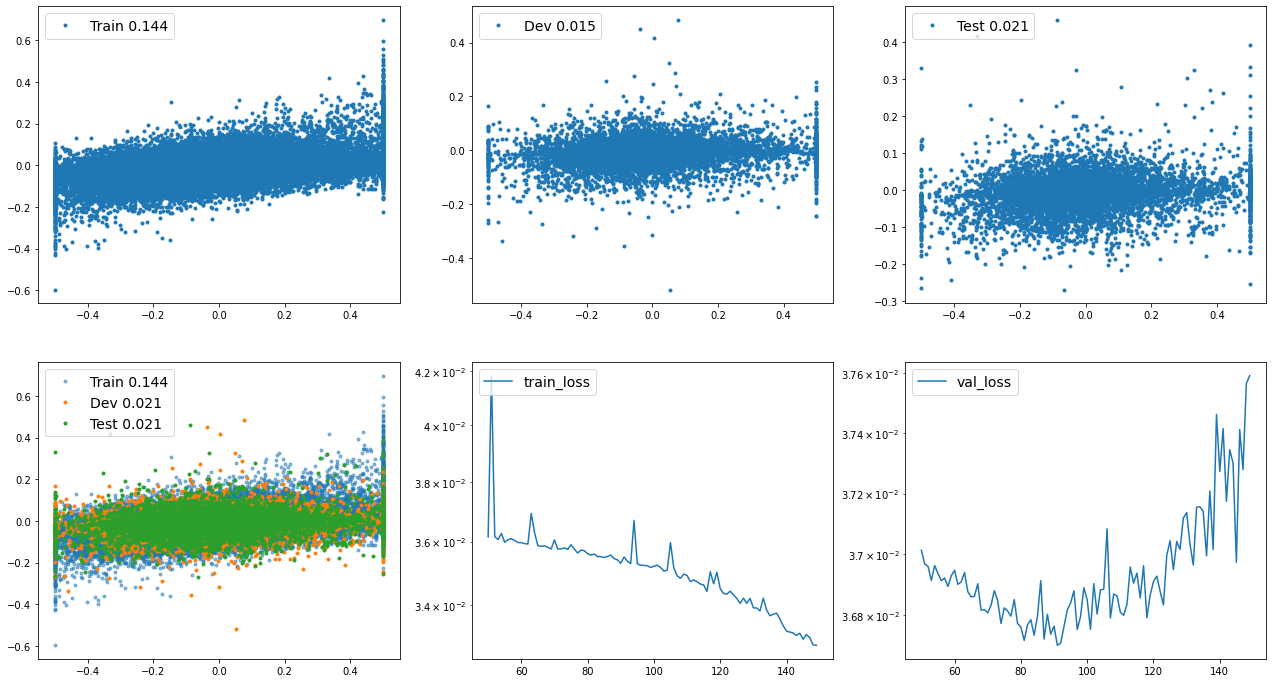

In [101]:
y_train_predict=nn_model.predict(x_train)
y_dev_predict=nn_model.predict(x_dev)
y_test_predict=nn_model.predict(x_test)

fig,ax=plt.subplots(2,3, figsize=(22, 12))
ax=fig.axes
train_score=get_score(y_train_predict, y_train)
dev_score=get_score(y_dev_predict, y_dev)
test_score=get_score(y_test_predict, y_test)

ax[0].plot(y_train.flatten(), y_train_predict.flatten(), '.', label='Train '+str(train_score)[:5])
ax[1].plot(y_dev.flatten(), y_dev_predict.flatten(), '.', label='Dev '+str(dev_score)[:5])
ax[2].plot(y_test.flatten(), y_test_predict.flatten(), '.',label='Test '+str(test_score)[:5])

ax[3].plot(y_train.flatten(), y_train_predict.flatten(), '.',label='Train '+str(train_score)[:5], alpha=0.5)
ax[3].plot(y_dev.flatten(), y_dev_predict.flatten(), '.',label='Dev '+str(test_score)[:5])
ax[3].plot(y_test.flatten(), y_test_predict.flatten(), '.',label='Test '+str(test_score)[:5])

ind_start=50
n_total=len(model_history.history['loss'])
ax[4].semilogy(np.arange(ind_start, n_total), model_history.history['loss'][ind_start:n_total+1], label='train_loss')
ax[5].semilogy(np.arange(ind_start, n_total), model_history.history['val_loss'][ind_start:n_total+1], label='val_loss')

for i in range(6):
    ax[i].legend(fontsize=14,loc=2)